# Fits and characterizes final model for 12-week outcome

Gaylen Fronk  
June 5, 2024

### Set Up Environment

In [ ]:
study <- "match"
version <- "v6"
cv <- "kfold"
y_col_name <- "pp_hybrid_wk12_outcome"


Packages for script

In [ ]:

library(tidymodels)


── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.5      ✔ recipes      1.0.10
✔ dials        1.2.1      ✔ rsample      1.2.1 
✔ dplyr        1.1.4      ✔ tibble       3.2.1 
✔ ggplot2      3.5.1      ✔ tidyr        1.3.1 
✔ infer        1.0.7      ✔ tune         1.2.1 
✔ modeldata    1.3.0      ✔ workflows    1.1.4 
✔ parsnip      1.2.1      ✔ workflowsets 1.1.0 
✔ purrr        1.0.2      ✔ yardstick    1.3.1 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ stringr   1.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ stringr::fixed()    masks recipes::fixed()
✖ dplyr::lag()        masks stats::lag()
✖ readr::spec()       masks yardstick::spec()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Attaching package: 'probably'

The following objects are masked from 'package:base':

    as.factor, as.ordered

here() starts at C:/Users/gfronk/Documents/GitHub/study_match

ℹ SHA-1 hash of file is "c045eee2655a18dc85e715b78182f176327358a7"

ℹ SHA-1 hash of file is "75cc6f7b855da59c240908bd936834b4da01285b"

Handle conflicts

In [ ]:

options(conflicts.policy = "depends.ok")


Absolute paths

In [ ]:
switch (Sys.info()[['sysname']],
        # PC paths
        Windows = {
          path_input <- stringr::str_c("P:/studydata/match/chtc/", 
                                       y_col_name)
          path_models <- stringr::str_c("P:/studydata/match/models/", 
                                        y_col_name)},
        
        # IOS paths
        Darwin = {
          path_input <- stringr::str_c("/Volumes/private/studydata/match/chtc/", 
                                       y_col_name)
          path_models <- stringr::str_c("/Volumes/private/studydata/match/models/", 
                                        y_col_name)},
        
        # Linux paths
        Linux = {
          path_input <- stringr::str_c("~/mnt/private/studydata/match/chtc/", 
                                       y_col_name)
          path_models <- stringr::str_c("~/mnt/private/studydata/match/models/", 
                                        y_col_name)}
)


Chunk Defaults

In [ ]:

knitr::opts_chunk$set(attr.output='style="max-height: 500px;"')

options(tibble.width = Inf)
options(tibble.print_max = Inf)


### Read in best configuration

Selected in 1_metrics_inner (k-fold CV)

In [ ]:
best_config <- read_csv(file.path(path_models, 
                                  str_c("best_config_", version, ".csv")),
                        show_col_types = FALSE)

glimpse(best_config)


Rows: 1
Columns: 9
$ n_jobs      <dbl> 10
$ algorithm   <chr> "glmnet_manual"
$ feature_set <chr> "scale_dummy"
$ hp1         <dbl> 0.1
$ hp2         <dbl> 0.1542244
$ hp3         <lgl> NA
$ resample    <chr> "none"
$ roc_auc     <dbl> 0.6830971
$ n_tx        <dbl> 50

### Fit best model in full dataset

**NOTE**: This model will only be used for 1) examining parameter estimates, and 2) ultimate dissemination.

In [ ]:
batch_names <- list.dirs(path_input, full.names = FALSE, recursive = FALSE) 

batch_name <- batch_names[str_detect(batch_names, "train") & 
                            str_detect(batch_names, cv) &
                            str_detect(batch_names, version) &
                            str_detect(batch_names, best_config$algorithm)] 

path_batch <- file.path(path_input, batch_name)
source(file.path(path_batch, "input", "training_controls.R"))

d <- read_csv(file.path(path_batch, "input", "data_trn.csv"), 
              show_col_types = FALSE) 

d_outcomes <- d |> 
  select(subid, ends_with("outcome") & contains("hybrid"))

d <- format_data(d) 

rec <- build_recipe(d = d, config = best_config)

rec_prepped_full <- rec |> 
  prep(training = d, strings_as_factors = FALSE)

feat_all <- rec_prepped_full |> 
  bake(new_data = NULL)

model_best_full <- fit_best_model(best_model = best_config, 
                                  feat = feat_all, 
                                  ml_mode = "classification")


### Model coefficients

**NOTE**: Coefficients are naturally inverted (i.e., positive class \[abstinence\] treated as first \[vs. second\] class). Here, we multiply coefficients by -1 to align the direction of coefficients with the rest of our analyses. Once flipped (i.e., as they appear below)…

A *positive coefficient* indicates that increases in the feature *increase* the likelihood of abstinence. For example, increases in motivation to quit (“motive_quit_order”) *increase* the likelihood of abstinence.

A *negative coefficient* indicates that increases in the feature *decrease* the likelihood of smoking. For example, increases in carbon monoxide (“co”) *decrease* the likelihood of abstinence.

In [ ]:
model_tidy <- tidy(model_best_full)


Loaded glmnet 4.1-8

In [ ]:

retained_vars <- model_tidy |> 
  mutate(estimate = estimate * -1) |> 
  filter(abs(estimate) > 0) |> 
  select(-penalty) |> 
  arrange(desc(abs(estimate)))

knitr::kable(retained_vars, digits = 4)


  -----------------------------------------------------------------------------------
  term                                                                       estimate
  ------------------------------------------------------------------------ ----------
  (Intercept)                                                                 -0.9527

  co                                                                          -0.1268

  race_ehr_white                                                               0.1130

  wisdm37_en_goad_scale                                                       -0.0791

  treatment_varenicline_x_confident_quit_order_09                              0.0730

  age_ehr                                                                      0.0696

  wsws_crave_scale                                                            -0.0677

  alc_qty_order_09                                                             0.0571

  race_ehr_black_african_american                                             -0.0569

  alc_freq_order_02                                                            0.0524

  treatment_varenicline_x_income_order_1                                      -0.0522

  longest_quit_order_2                                                        -0.0496

  life_satisfaction_order_2                                                   -0.0473

  confident_quit_order_09                                                      0.0470

  time_around_smokers_order_1                                                  0.0465

  income_order_1                                                              -0.0464

  motive_quit_order_10                                                         0.0461

  treatment_patch_x_time_around_smokers_order_3                               -0.0431

  last_rct_quit_order_7                                                       -0.0421

  treatment_varenicline_x_marital_status_ehr_divorced                         -0.0419

  treatment_combo_nrt_x_alc_freq_order_10                                      0.0409

  wisdm37_tolerance_scale                                                     -0.0408

  smoke_menthol_no                                                             0.0374

  sip2r_total_scale                                                           -0.0360

  shp_total_scale                                                              0.0358

  treatment_varenicline_x_berlin_7_order_2                                     0.0332

  employment_unemployed                                                       -0.0327

  treatment_combo_nrt_x_smoke_menthol_yes                                     -0.0327

  time_around_smokers_order_3                                                 -0.0323

  treatment_combo_nrt_x_berlin_7_order_5                                       0.0315

  alc_freq_order_05                                                           -0.0314

  treatment_patch_x_tried_chantix_yes                                         -0.0309

  smoke_menthol_yes                                                           -0.0303

  alc_binge_order_06                                                          -0.0299

  treatment_varenicline_x_used_pipe_tried                                      0.0296

  hdsm_pain                                                                   -0.0290

  treatment_combo_nrt_x_last_rct_quit_order_5                                  0.0286

  treatment_combo_nrt_x_time_around_smokers_weekend_order_4                   -0.0281

  years_smoke                                                                  0.0277

  cigs_per_day_heaviest                                                       -0.0275

  live_with_smoker_yes                                                        -0.0272

  hdsm_tired                                                                  -0.0259

  life_satisfaction_order_5                                                    0.0254

  tot_quit_attempt                                                             0.0235

  treatment_combo_nrt_x_time_around_smokers_weekend_order_2                    0.0227

  treatment_varenicline_x_alc_qty_order_09                                     0.0225

  alc_binge_order_08                                                           0.0215

  wsws_hunger_scale                                                            0.0213

  life_enjoyment_order_3                                                      -0.0205

  alc_freq_order_10                                                            0.0188

  treatment_combo_nrt_x_motive_quit_order_09                                  -0.0170

  treatment_varenicline_x_life_satisfaction_order_5                            0.0160

  treatment_varenicline_x_race_ehr_white                                       0.0159

  motive_quit_order_09                                                        -0.0159

  treatment_combo_nrt_x_longest_quit_order_2                                  -0.0158

  longest_quit_order_8                                                         0.0148

  time_around_smokers_order_5                                                 -0.0140

  treatment_combo_nrt_x_smoke_menthol_no                                       0.0131

  last_rct_quit_order_6                                                        0.0126

  longest_quit_order_4                                                        -0.0125

  cigs_per_day                                                                -0.0123

  treatment_patch_x_tried_zyban_yes                                           -0.0114

  alc_freq_order_08                                                            0.0109

  marital_status_ehr_married                                                   0.0104

  treatment_varenicline_x_used_e_cig_never_tried                               0.0097

  phq9_severity_scale_order_2                                                 -0.0092

  treatment_varenicline_x_life_enjoyment_order_4                               0.0090

  dts_absorption_scale                                                        -0.0080

  wisdm37_auto_scale                                                          -0.0077

  used_pipe_never_tried                                                       -0.0074

  treatment_combo_nrt_x_live_with_smoker_live_alone_or_only_with_partner       0.0074

  treatment_patch_x_psych_depression_yes                                      -0.0068

  treatment_varenicline_x_time_around_smokers_order_4                          0.0067

  treatment_varenicline_x_motive_quit_order_10                                 0.0067

  treatment_varenicline_x_quit_success_30d_order_7                             0.0067

  treatment_combo_nrt_x_life_enjoyment_order_7                                 0.0065

  treatment_varenicline_x_income_order_6                                       0.0062

  life_enjoyment_order_5                                                      -0.0062

  dts_tolerance_scale                                                         -0.0059

  treatment_combo_nrt_x_confident_quit_order_10                               -0.0047

  time_around_smokers_weekend_order_2                                          0.0047

  treatment_combo_nrt_x_life_satisfaction_order_5                              0.0045

  treatment_varenicline_x_work_ban_no_smoking_allowed                          0.0041

  treatment_combo_nrt_x_psych_depression_yes                                  -0.0036

  treatment_patch_x_close_smoke_co_worker_yes                                  0.0034

  income_order_7                                                               0.0031

  treatment_combo_nrt_x_time_around_smokers_weekend_order_1                    0.0031

  dts_regulation_scale                                                        -0.0031

  treatment_varenicline_x_employment_employed_full_time                        0.0029

  treatment_varenicline_x_life_enjoyment_order_5                              -0.0028

  treatment_combo_nrt_x_motive_quit_order_10                                   0.0027

  close_smoke_friend_yes                                                       0.0023

  close_smoke_friend_no                                                       -0.0023

  hrqol_1_order_4                                                              0.0022

  used_pipe_tried                                                              0.0020

  treatment_patch_x_spouse_smoke_yes                                          -0.0018

  confident_quit_order_07                                                      0.0017

  berlin_7_order_4                                                            -0.0014

  treatment_varenicline_x_alc_binge_order_09                                   0.0013

  treatment_patch_x_close_smoke_friend_no                                     -0.0012

  treatment_varenicline_x_employment_unemployed                               -0.0011

  phq9_severity_scale_order_3                                                  0.0011

  hrqol_2                                                                     -0.0010

  treatment_patch_x_time_around_smokers_weekend_order_3                       -0.0009

  treatment_combo_nrt_x_berlin_6_order_3                                       0.0009

  treatment_varenicline_x_marital_status_ehr_married                           0.0006

  longest_quit_order_5                                                         0.0004

  alc_freq_order_03                                                           -0.0003

  treatment_combo_nrt_x_marital_status_ehr_never_married                      -0.0002

  wisdm37_cue_scale                                                           -0.0002

  treatment_varenicline_x_spouse_smoke_no                                      0.0001
  -----------------------------------------------------------------------------------


17.18% of features were retained by the glmnet solution (111 features of a total considered 646 features).

In [ ]:
retained_vars_tx <- retained_vars |> 
  filter(str_detect(term, "treatment_")) |> 
  arrange(desc(abs(estimate))) 

knitr::kable(retained_vars_tx, digits = 4)


  -----------------------------------------------------------------------------------
  term                                                                       estimate
  ------------------------------------------------------------------------ ----------
  treatment_varenicline_x_confident_quit_order_09                              0.0730

  treatment_varenicline_x_income_order_1                                      -0.0522

  treatment_patch_x_time_around_smokers_order_3                               -0.0431

  treatment_varenicline_x_marital_status_ehr_divorced                         -0.0419

  treatment_combo_nrt_x_alc_freq_order_10                                      0.0409

  treatment_varenicline_x_berlin_7_order_2                                     0.0332

  treatment_combo_nrt_x_smoke_menthol_yes                                     -0.0327

  treatment_combo_nrt_x_berlin_7_order_5                                       0.0315

  treatment_patch_x_tried_chantix_yes                                         -0.0309

  treatment_varenicline_x_used_pipe_tried                                      0.0296

  treatment_combo_nrt_x_last_rct_quit_order_5                                  0.0286

  treatment_combo_nrt_x_time_around_smokers_weekend_order_4                   -0.0281

  treatment_combo_nrt_x_time_around_smokers_weekend_order_2                    0.0227

  treatment_varenicline_x_alc_qty_order_09                                     0.0225

  treatment_combo_nrt_x_motive_quit_order_09                                  -0.0170

  treatment_varenicline_x_life_satisfaction_order_5                            0.0160

  treatment_varenicline_x_race_ehr_white                                       0.0159

  treatment_combo_nrt_x_longest_quit_order_2                                  -0.0158

  treatment_combo_nrt_x_smoke_menthol_no                                       0.0131

  treatment_patch_x_tried_zyban_yes                                           -0.0114

  treatment_varenicline_x_used_e_cig_never_tried                               0.0097

  treatment_varenicline_x_life_enjoyment_order_4                               0.0090

  treatment_combo_nrt_x_live_with_smoker_live_alone_or_only_with_partner       0.0074

  treatment_patch_x_psych_depression_yes                                      -0.0068

  treatment_varenicline_x_time_around_smokers_order_4                          0.0067

  treatment_varenicline_x_motive_quit_order_10                                 0.0067

  treatment_varenicline_x_quit_success_30d_order_7                             0.0067

  treatment_combo_nrt_x_life_enjoyment_order_7                                 0.0065

  treatment_varenicline_x_income_order_6                                       0.0062

  treatment_combo_nrt_x_confident_quit_order_10                               -0.0047

  treatment_combo_nrt_x_life_satisfaction_order_5                              0.0045

  treatment_varenicline_x_work_ban_no_smoking_allowed                          0.0041

  treatment_combo_nrt_x_psych_depression_yes                                  -0.0036

  treatment_patch_x_close_smoke_co_worker_yes                                  0.0034

  treatment_combo_nrt_x_time_around_smokers_weekend_order_1                    0.0031

  treatment_varenicline_x_employment_employed_full_time                        0.0029

  treatment_varenicline_x_life_enjoyment_order_5                              -0.0028

  treatment_combo_nrt_x_motive_quit_order_10                                   0.0027

  treatment_patch_x_spouse_smoke_yes                                          -0.0018

  treatment_varenicline_x_alc_binge_order_09                                   0.0013

  treatment_patch_x_close_smoke_friend_no                                     -0.0012

  treatment_varenicline_x_employment_unemployed                               -0.0011

  treatment_patch_x_time_around_smokers_weekend_order_3                       -0.0009

  treatment_combo_nrt_x_berlin_6_order_3                                       0.0009

  treatment_varenicline_x_marital_status_ehr_married                           0.0006

  treatment_combo_nrt_x_marital_status_ehr_never_married                      -0.0002

  treatment_varenicline_x_spouse_smoke_no                                      0.0001
  -----------------------------------------------------------------------------------


42.34% of the retained features were treatment interaction features (47 treatment features of 111 retained features). Of the 435 available treatment interaction features, 11% were retained.

### Calculate and calibrate probabilities

Make triplicate dataset

In [ ]:
d_patch <- d |> 
  mutate(treatment = "patch") 

d_combo <- d |> 
  mutate(treatment = "combo_nrt")

d_varen <- d |> 
  mutate(treatment = "varenicline")

d_trip <- bind_rows(d_patch, d_combo) |> 
  bind_rows(d_varen) |> 
  mutate(treatment = factor(treatment, 
                            levels = c(
                              "patch",
                              "varenicline",
                              "combo_nrt")))


Make function to: 1) hold out each sub once, 2) fit model with remaining 1085 subs, 3) get 3 raw predictions for held-out sub, 4) get calibrated predictions for held-out sub

In [ ]:
get_triple_probs <- function(i_sub, best_config, d, d_trip){
  
  # hold out single subject
  d_out <- d_trip |> 
    filter(subid == i_sub)
  
  d_in <- d |> 
    filter(subid != i_sub)
  
  # prep recipe 
  rec <- build_recipe(d = d_in, config = best_config)
  rec_prepped <- rec |> 
    prep(training = d_in, strings_as_factors = FALSE)
  
  # bake feat_in and feat_out
  feat_in <- rec_prepped |> 
    bake(new_data = NULL)
  
  feat_out <- rec_prepped |> 
    bake(new_data = d_out)
  
  # fit model
  model_best <- fit_best_model(best_config, feat = feat_in,
                               "classification")
  
  # raw (uncalibrated) predictions
  preds_prob <- predict(model_best, feat_out,
                        type = "prob")
  
  # fit calibration model
  set.seed(2468)
  cal_split <- d_in |> 
    initial_split(prop = 3/4, strata = y)
  d_cal_in <- training(cal_split) 
  d_cal_out <- testing(cal_split)
  
  rec_cal_prepped <- rec |> 
    prep(training = d_cal_in, strings_as_factors = FALSE)
  
  feat_cal_in <- rec_cal_prepped |> 
    bake(new_data = NULL) 
  
  feat_cal_out <- rec_cal_prepped |> 
    bake(new_data = d_cal_out) 
  
  model_cal <- fit_best_model(best_config, feat = feat_cal_in, "classification")
  
  # beta calibration
  beta <- predict(model_cal, feat_cal_out,
                  type = "prob") |>
    mutate(truth = feat_cal_out$y) |>
    cal_estimate_beta(truth = truth,
                      estimate = dplyr::starts_with(".pred_"),
                      smooth = TRUE)
  preds_prob_beta <- preds_prob |>
    cal_apply(beta)
  
  # iso calibration
  iso <- predict(model_cal, feat_cal_out,
                 type = "prob") |>
    mutate(truth = feat_cal_out$y) |>
    cal_estimate_isotonic(truth = truth,
                          estimate = dplyr::starts_with(".pred_"))
  preds_prob_iso <- preds_prob |>
    cal_apply(iso)
  
  # logistic calibration
  logi <- predict(model_cal, feat_cal_out,
                  type = "prob") |>
    mutate(truth = feat_cal_out$y) |>
    cal_estimate_logistic(truth = truth,
                          estimate = dplyr::starts_with(".pred_"),
                          smooth = TRUE)
  preds_prob_logi <- preds_prob |>
    cal_apply(logi)
  
  # combine raw and calibrated probs
  probs <- tibble(subid = d_out$subid,
                  tx = d_out$treatment,
                  prob_raw = preds_prob[[str_c(".pred_", y_level_pos)]],
                  prob_beta = preds_prob_beta[[str_c(".pred_", y_level_pos)]],
                  prob_iso = preds_prob_iso[[str_c(".pred_", y_level_pos)]],
                  prob_logi = preds_prob_logi[[str_c(".pred_", y_level_pos)]]) 
}


Map over participants so that each is held-out once

In [ ]:
if(file.exists(file.path(path_models, 
                         str_c("trip_probs_", version, ".csv")))) {
  all_probs <- read_csv(file.path(path_models, 
                                  str_c("trip_probs_", version, ".csv")),
                        show_col_types = FALSE)
} else {
  all_probs <- d$subid |> 
    map(\(i_sub) get_triple_probs(i_sub, best_config, d, d_trip)) |> 
    list_rbind()
  
  all_probs |> 
    write_csv(file.path(path_models, 
                        str_c("trip_probs_", version, ".csv")))
}


### Make AIM 2 Dataset

Pivot probabilities into wide format & select only raw probability (based on calibration validity check below)

In [ ]:
raw_probs_wide <- all_probs |> 
  select(subid, tx, prob_raw) |> 
  pivot_wider(names_prefix = "prob_",
              names_from = tx,
              values_from = prob_raw)

glimpse(raw_probs_wide)


Rows: 1,086
Columns: 4
$ subid            <dbl> 20010, 20015, 20030, 20049, 20051, 20072, 20077, 2008…
$ prob_patch       <dbl> 0.1610573, 0.3272543, 0.2825550, 0.3491451, 0.4286955…
$ prob_combo_nrt   <dbl> 0.1860530, 0.3877443, 0.3185973, 0.4018380, 0.4309108…
$ prob_varenicline <dbl> 0.1601103, 0.5184533, 0.2743758, 0.4938523, 0.4883779…

Join with d & create new variables

In [ ]:
set.seed(52592)
d_aim_2 <- d |> 
  select(subid, tx_rct = treatment, outcome_rct_wk12 = y) |> 
  left_join(raw_probs_wide, by = "subid") |> 
    mutate(tx_best = case_when(
    prob_patch > prob_combo_nrt & prob_patch > prob_varenicline ~ "patch",
    prob_combo_nrt > prob_patch & prob_combo_nrt > prob_varenicline ~ "combo_nrt",
    prob_varenicline > prob_patch & prob_varenicline > prob_combo_nrt ~ "varenicline",
    TRUE ~ NA_character_
  )) |> 
  # handle ties (prefer CNRT and varenicline per clinical guidelines)
  # sample among those if tied
  mutate(tx_best = if_else(is.na(tx_best), case_when(
    prob_patch == prob_combo_nrt ~ "combo_nrt",
    prob_patch == prob_varenicline ~ "varenicline",
    prob_combo_nrt == prob_varenicline ~ sample(c("combo_nrt",
                                                  "varenicline"), 1),
    TRUE ~ NA_character_
  ), tx_best)) |>  
  mutate(prob_best = case_when(
    tx_best == "patch" ~ prob_patch,
    tx_best == "combo_nrt" ~ prob_combo_nrt,
    tx_best == "varenicline" ~ prob_varenicline,
    TRUE ~ NA_real_
  )) |> 
  mutate(tx_best = factor(tx_best, 
                          levels = c(
                            "patch",
                            "varenicline",
                            "combo_nrt"))) |> 
  mutate(tx_match = if_else(tx_best == tx_rct, TRUE, FALSE)) |> 
  left_join(d_outcomes, by = "subid") |> 
  select(-pp_hybrid_wk12_outcome, -pp_hybrid_wk1_outcome, 
         -pp_hybrid_yr3_outcome, -pp_hybrid_wk52_outcome) |> 
  rename(outcome_rct_wk4 = pp_hybrid_wk4_outcome,
         outcome_rct_wk26 = pp_hybrid_wk26_outcome) |> 
  relocate(subid, tx_rct, tx_best, tx_match,
           prob_best, starts_with("outcome"), starts_with("prob"))

glimpse(d_aim_2)


Rows: 1,086
Columns: 11
$ subid            <dbl> 20010, 20015, 20030, 20049, 20051, 20072, 20077, 2008…
$ tx_rct           <fct> patch, combo_nrt, patch, varenicline, patch, combo_nr…
$ tx_best          <fct> combo_nrt, varenicline, combo_nrt, varenicline, varen…
$ tx_match         <lgl> FALSE, FALSE, FALSE, TRUE, FALSE, FALSE, FALSE, FALSE…
$ prob_best        <dbl> 0.1860530, 0.5184533, 0.3185973, 0.4938523, 0.4883779…
$ outcome_rct_wk12 <fct> smoking, smoking, smoking, abstinent, smoking, smokin…
$ outcome_rct_wk4  <chr> "smoking", "smoking", "smoking", "smoking", "smoking"…
$ outcome_rct_wk26 <chr> "smoking", "smoking", "smoking", "abstinent", "smokin…
$ prob_patch       <dbl> 0.1610573, 0.3272543, 0.2825550, 0.3491451, 0.4286955…
$ prob_combo_nrt   <dbl> 0.1860530, 0.3877443, 0.3185973, 0.4018380, 0.4309108…
$ prob_varenicline <dbl> 0.1601103, 0.5184533, 0.2743758, 0.4938523, 0.4883779…

Quick EDA checks

In [ ]:
# confirm logic worked as expected
head(d_aim_2)


# A tibble: 6 × 11
  subid tx_rct      tx_best     tx_match prob_best outcome_rct_wk12
  <dbl> <fct>       <fct>       <lgl>        <dbl> <fct>           
1 20010 patch       combo_nrt   FALSE        0.186 smoking         
2 20015 combo_nrt   varenicline FALSE        0.518 smoking         
3 20030 patch       combo_nrt   FALSE        0.319 smoking         
4 20049 varenicline varenicline TRUE         0.494 abstinent       
5 20051 patch       varenicline FALSE        0.488 smoking         
6 20072 combo_nrt   varenicline FALSE        0.467 smoking         
  outcome_rct_wk4 outcome_rct_wk26 prob_patch prob_combo_nrt prob_varenicline
  <chr>           <chr>                 <dbl>          <dbl>            <dbl>
1 smoking         smoking               0.161          0.186            0.160
2 smoking         smoking               0.327          0.388            0.518
3 smoking         smoking               0.283          0.319            0.274
4 smoking         abstinent             0.349  

# A tibble: 3 × 3
  tx_best         n   prop
  <fct>       <int>  <dbl>
1 patch          68 0.0626
2 varenicline   689 0.634 
3 combo_nrt     329 0.303 

# A tibble: 2 × 3
  tx_match     n  prop
  <lgl>    <int> <dbl>
1 FALSE      679 0.625
2 TRUE       407 0.375

# A tibble: 6 × 4
# Groups:   tx_rct [3]
  tx_rct      tx_match     n   prop
  <fct>       <lgl>    <int>  <dbl>
1 patch       FALSE      227 0.942 
2 patch       TRUE        14 0.0581
3 varenicline FALSE      154 0.363 
4 varenicline TRUE       270 0.637 
5 combo_nrt   FALSE      298 0.708 
6 combo_nrt   TRUE       123 0.292 

Write out

In [ ]:
d_aim_2 |> 
  write_csv(file.path(path_models, str_c("aim_2_", version, "_", 
                                         y_col_name, ".csv")))


### Validity check: Model Calibration

Make wide format for all calibrated probabilities

In [ ]:
all_probs_wide <- all_probs |> 
  rename_with(~ str_replace(.x, "prob_", ""), .cols = starts_with("prob_")) |> 
  pivot_wider(
    names_from = tx,
    values_from = c(raw, beta, iso, logi),
    names_glue = "{.value}_{tx}"
  )


Set up validity check data

In [ ]:
d_valid <- d_aim_2 |> 
  select(subid, tx_rct, outcome_rct_wk12) |> 
  left_join(all_probs_wide, by = "subid") |> 
  mutate(beta = case_when(
    tx_rct == "patch" ~ beta_patch,
    tx_rct == "combo_nrt" ~ beta_combo_nrt,
    tx_rct == "varenicline" ~ beta_varenicline,
    TRUE ~ NA_real_
  ),
  raw = case_when(
    tx_rct == "patch" ~ raw_patch,
    tx_rct == "combo_nrt" ~ raw_combo_nrt,
    tx_rct == "varenicline" ~ raw_varenicline,
    TRUE ~ NA_real_
  ),
  isotonic = case_when(
    tx_rct == "patch" ~ iso_patch,
    tx_rct == "combo_nrt" ~ iso_combo_nrt,
    tx_rct == "varenicline" ~ iso_varenicline,
    TRUE ~ NA_real_
  ),
  logistic = case_when(
    tx_rct == "patch" ~ logi_patch,
    tx_rct == "combo_nrt" ~ logi_combo_nrt,
    tx_rct == "varenicline" ~ logi_varenicline,
    TRUE ~ NA_real_
  )) |> 
  select(subid, outcome_rct_wk12, beta, raw, isotonic, logistic) 


#### Comparison of means

Compare mean abstinence from RCT to predicted probabilities for RCT tx across calibrations

In [ ]:
d_valid |> 
  mutate(outcome_rct = if_else(outcome_rct_wk12 == "abstinent", 1, 0)) |> 
  summarize(mean_rct = mean(outcome_rct),
            mean_beta = mean(beta),
            mean_iso = mean(isotonic),
            mean_logi = mean(logistic),
            mean_raw = mean(raw))


# A tibble: 1 × 5
  mean_rct mean_beta mean_iso mean_logi mean_raw
     <dbl>     <dbl>    <dbl>     <dbl>    <dbl>
1    0.290     0.284    0.205     0.288    0.290

Raw probabilities match best, though beta and logistic calibration are close.

#### Plots

Pivot data longer for required format

In [ ]:
d_plot <- d_valid |> 
  pivot_longer(
    cols = c(beta, raw, isotonic, logistic),
    names_to = "method",
    values_to = ".pred_abstinent"
  )


Make plots by calibration method

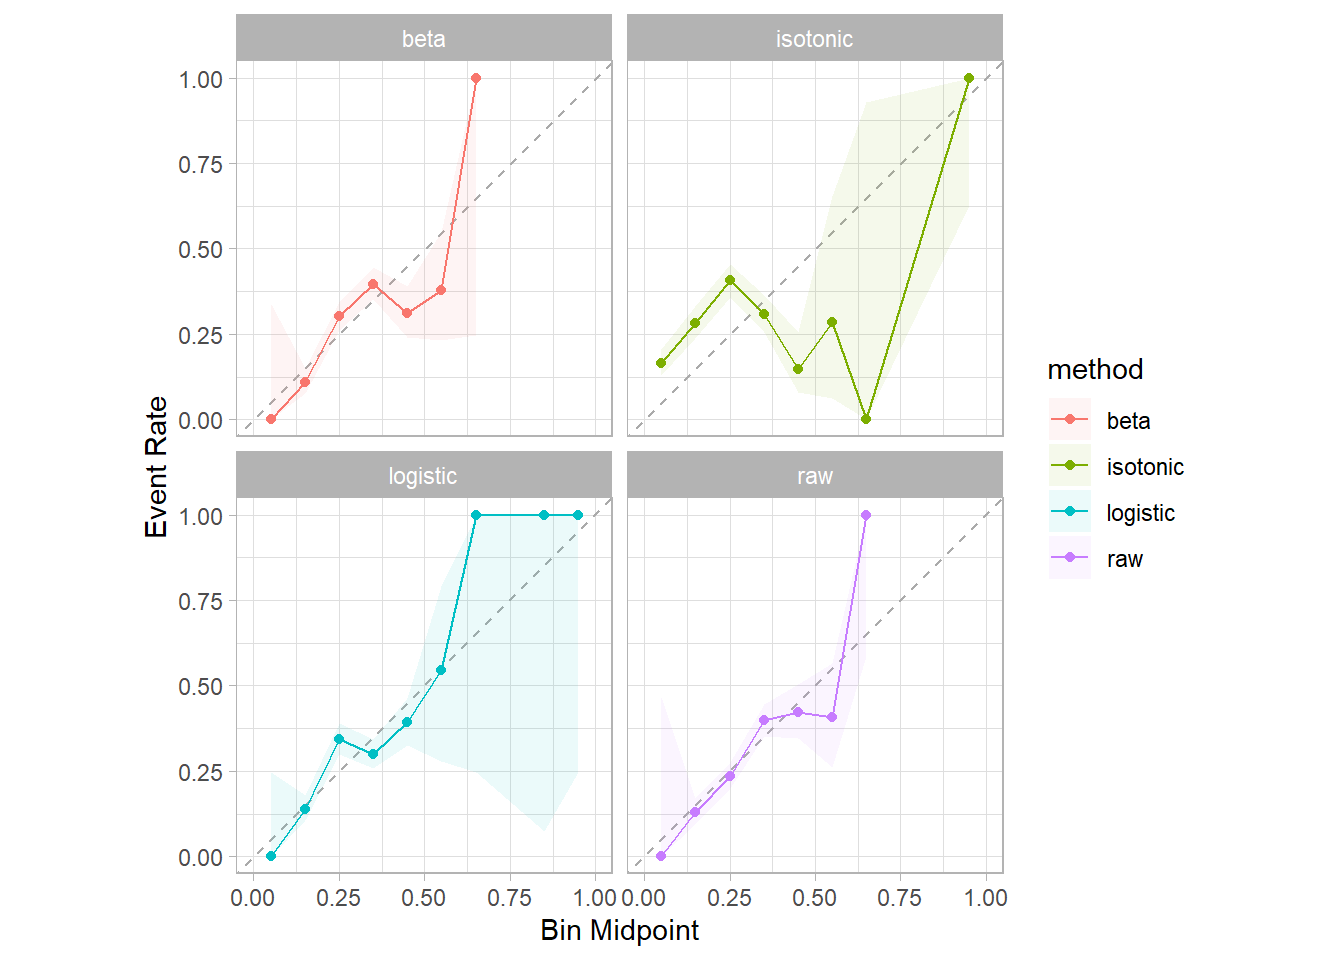

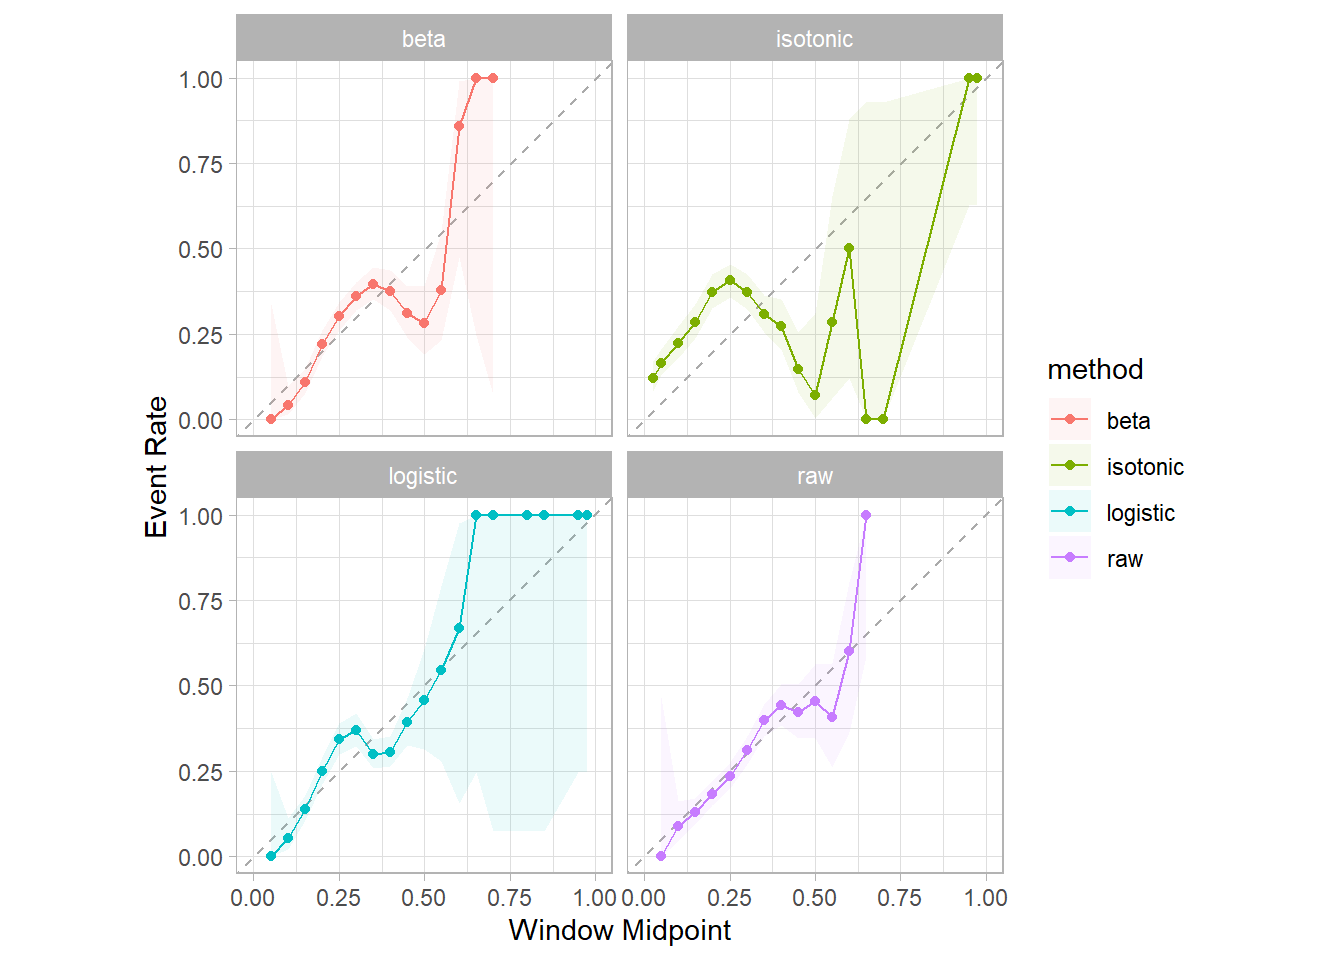

In [ ]:
d_plot |> 
  cal_plot_breaks(truth = outcome_rct_wk12, 
                  estimate = .pred_abstinent,
                  .by = method)


Raw and logistic look best. Raw follows the diagonal more closely in the first half, but logistic spans the full range. Upper half of logistic range has a very wide confidence interval/spread.

#### Brier score

Beta calibration

In [ ]:
brier_class_vec(truth = d_valid$outcome_rct_wk12,
                estimate = d_valid$beta)


[1] 0.1978052

Logistic calibration

In [ ]:
brier_class_vec(truth = d_valid$outcome_rct_wk12,
                estimate = d_valid$logistic)


[1] 0.1993562

Isotonic calibration

In [ ]:
brier_class_vec(truth = d_valid$outcome_rct_wk12,
                estimate = d_valid$isotonic)


[1] 0.21211

Raw calibration

In [ ]:
brier_class_vec(truth = d_valid$outcome_rct_wk12,
                estimate = d_valid$raw)


[1] 0.1916881

Raw calibration has the lowest Brier score (though all are relatively similar). In keeping with the other methods above, beta and logistic are next-best followed by isotonic last.